# 近二十年代用指标

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os
from matplotlib import pyplot as plt


# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

In [2]:
sw = pd.read_csv(cfg.db.year_book.sw)
gw = pd.read_csv(cfg.db.year_book.gw)

In [3]:
COLS = {
    "内蒙古": "Neimeng",
    "宁夏": "Ningxia",
    "山东": "Shandong",
    "山西": "Shaanxi",
    "河南": "Henan",
    "甘肃": "Gansu",
    "陕西": "Shanxi",
    "青海": "Qinghai",
}

NAMES = {
    "农田灌溉": "Irrigation",
    "年份": "Year",
    "省份": "Province",
    "工业": "Industry",
    "城镇公共": "Services",
    "居民生活": "Domestic",
    "生态环境": "Environment",
    "林牧渔畜": "Livestock",
}


def get_irr_wu(data: pd.DataFrame, use_cols=None, value="农田灌溉", long=False):
    """清洗农田灌溉用水数据"""
    if use_cols is None:
        use_cols = COLS.keys()
    # 关注取水量而不是耗水量
    df = data[data["项目"] == "取水量"]
    # 仅采用农田灌溉的用水比例
    df = df.pivot_table(index="年份", columns="省份", values=value, aggfunc="sum")
    # 选取使用的列，转换成浮点数
    short = df[use_cols].apply(pd.to_numeric, errors="coerce").rename(COLS, axis=1)
    if long:
        return pd.melt(df.reset_index(), id_vars="年份", value_name=value)
    else:
        return short


# 产生直接惠益的用水方式
direct = [
    "农田灌溉",
    "居民生活",
    "林牧渔畜",
]

# 产生间接惠益的用水方式
indirect = ["工业", "城镇公共", "生态环境"]
ITEMS_CH = [*direct, *indirect]
ITEMS_EN = [NAMES[item] for item in ITEMS_CH]


def merge_data(dataset):
    data = None
    for col in [*direct, *indirect]:
        tmp_data = get_irr_wu(dataset, value=col).rename(COLS, axis=1)
        tmp_data = pd.melt(tmp_data.reset_index(), id_vars="年份", value_name=col)
        if data is None:
            data = tmp_data
        else:
            data = pd.merge(data, tmp_data, on=["年份", "省份"])
    return data.rename(NAMES, axis=1)


merged_data = pd.merge(
    left=merge_data(sw),
    right=merge_data(gw),
    on=["Year", "Province"],
    suffixes=("_sw", "_gw"),
)

for col in ITEMS_EN:
    merged_data[col] = merged_data[f"{col}_sw"] + merged_data[f"{col}_gw"]
    merged_data = merged_data.drop([f"{col}_sw", f"{col}_gw"], axis=1)
merged_data.head()

,Year,Province,Irrigation,Domestic,Livestock,Industry,Services,Environment
0,2003,Neimeng,63.93,2.55,7.29,5.87,0.70,0.30
1,2004,Neimeng,73.43,1.86,7.70,6.36,0.90,0.33
2,2005,Neimeng,77.87,2.21,8.79,7.61,1.12,0.41
3,2006,Neimeng,77.08,2.18,8.29,8.85,1.52,0.55
4,2007,Neimeng,77.10,1.87,8.93,7.86,1.40,0.37


In [4]:
merged_data

,Year,Province,Irrigation,Domestic,Livestock,Industry,Services,Environment
0,2003,Neimeng,63.93,2.55,7.29,5.87,0.70,0.30
1,2004,Neimeng,73.43,1.86,7.70,6.36,0.90,0.33
2,2005,Neimeng,77.87,2.21,8.79,7.61,1.12,0.41
3,2006,Neimeng,77.08,2.18,8.29,8.85,1.52,0.55
4,2007,Neimeng,77.10,1.87,8.93,7.86,1.40,0.37
...,...,...,...,...,...,...,...,...
115,2013,Qinghai,9.74,1.01,2.04,1.45,0.88,0.16
116,2014,Qinghai,8.87,1.19,2.48,1.44,0.94,0.23
117,2015,Qinghai,8.89,1.22,2.66,1.56,0.91,0.31
118,2016,Qinghai,9.20,1.49,2.44,1.36,0.85,0.56


## Priority

In [5]:
from regimes_yrb.priority import direct_ratio

direct = [
    "农田灌溉",
    "居民生活",
    "林牧渔畜",
]

# 产生间接惠益的用水方式
indirect_en = [NAMES[i] for i in indirect]
direct_en = [NAMES[i] for i in direct]

data = merged_data.groupby("Year").sum(numeric_only=True)

# 计算比例
priority, priority_contributions = direct_ratio(
    data, indirect=indirect_en, direct=direct_en
)
priority

Year
2003    0.822317
2004    0.831131
2005    0.832563
2006    0.834028
2007    0.823034
2008    0.819254
2009    0.824591
2010    0.816029
2011    0.797288
2012    0.799217
2013    0.807863
2014    0.807998
2015    0.812540
2016    0.808951
2017    0.794444
dtype: float64

## Allocation

In [6]:
from regimes_yrb.allocation import calc_regional_entropy

REGIONS = {
    "Neimeng": "UR",
    "Ningxia": "UR",
    "Shandong": "DR",
    "Shaanxi": "MR",
    "Henan": "DR",
    "Gansu": "SR",
    "Shanxi": "MR",
    "Qinghai": "SR",
}

merged_data["Region"] = merged_data["Province"].replace(REGIONS)
allocation = calc_regional_entropy(merged_data, wu_cols=ITEMS_EN)
allocation

2003    0.966321
2004    0.956079
2005    0.948125
2006    0.948835
2007    0.954867
2008    0.953594
2009    0.946978
2010    0.950457
2011    0.959937
2012    0.955384
2013    0.944371
2014    0.944336
2015    0.944050
2016    0.951059
2017    0.950833
Name: Ratio, dtype: float64

## Stress

In [7]:
# 加载径流和水库数据
use_cols = {
    "唐乃亥": "SR",  # 唐乃亥控制源区
    "头道拐": "UR",  # 头道拐控制上游
    "花园口": "MR",  # 花园口控制中游
    "利津": "DR",  # 利津控制下游
}
# 径流数据
measured_runoff = pd.read_csv(cfg.db.runoff, index_col="年份")
measured_runoff = measured_runoff.loc[:, use_cols.keys()]
measured_runoff.rename(use_cols, axis=1, inplace=True)

# 水库库容数据
reservoirs_capacity = pd.read_csv(cfg.db.reservoirs, index_col=0)

# 水库库容累积相加数据
reservoirs_capacity_cumulating = reservoirs_capacity.cumsum()

In [10]:
from regimes_yrb.scarcity import calc_sfv

merged_data["Total water use"] = merged_data.sum(numeric_only=True, axis=1)

# 计算 SFV
sfv, sfv_regions = calc_sfv(
    measured_runoff,
    merged_data[merged_data["Year"] <= 2016],
    reservoirs_capacity_cumulating,
    inflexible_wu=["Domestic", "Livestock"],
)

/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/regimes_yrb/scarcity.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumptions["_inflexible_wu"] = consumptions.loc[:, inflexible_wu].sum(axis=1)


In [15]:
from regimes_yrb.index import integrated_water_governance_index

iwgi = integrated_water_governance_index(
    priority=priority,
    scarcity=sfv,
    allocation=allocation,
)
iwgi

,S,P,A,IWGI,stage
2003,0.485831,0.709182,1.000000,0.731671,P1
2004,0.347632,0.928444,0.543010,0.606362,P1
2005,0.000000,0.963842,0.184734,0.382859,P1
2006,0.102451,1.000000,0.216825,0.439759,P1
2007,0.102533,0.727109,0.488620,0.439420,P1
2008,0.098505,0.632418,0.431397,0.387440,P1
2009,0.277231,0.765963,0.132819,0.392004,P1
2010,0.721158,0.551313,0.290082,0.520851,P1
2011,1.000000,0.073493,0.715729,0.596407,P1
2012,0.662856,0.123182,0.511819,0.432619,P1


Text(0, 0.5, 'IWGI robustness test')

Text(0.5, 0, 'Year')

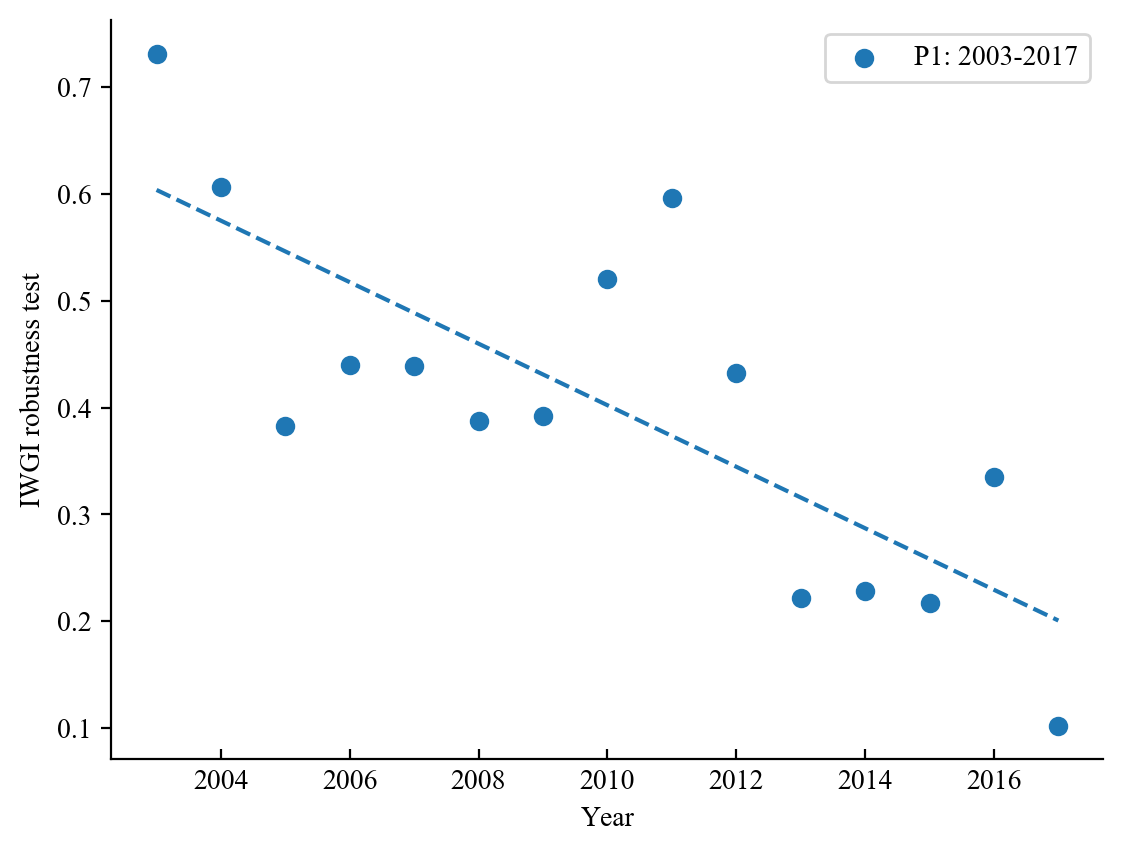

In [17]:
from regimes_yrb.allocation import calc_regional_entropy
from regimes_yrb.plot import plot_data
from regimes_yrb.tools.statistic import norm_zscore
from mksci_font import config_font
from regimes_yrb.plot import plot_pettitt_change_points
from matplotlib import pyplot as plt

ax1 = plot_pettitt_change_points(
    iwgi["IWGI"],
    returns="ax",
)
ax1.set_ylabel("IWGI robustness test")
# ax1.set_ylabel("分配方式")
# ax1.set_xlabel("年份")
ax1.set_xlabel("Year")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

plt.savefig("figures/sup/robustness.png", dpi=300)

# 数据导出
allocation.to_csv(cfg.db.results.A)